In [1]:
import os
import pandas as pd
import numpy as np

import joblib
import sidetable

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from itertools import combinations
from MetsDataByGender import get_mets_data
from MetsEvaluation import get_feature_importance, get_metric, get_calib_metric

from numpy import array
from matplotlib import pyplot as plt
%matplotlib inline

### Dataset

In [143]:
# fts_ctg : 'anthropometric', 'survey-based', 'synthesized'
# fts : Define features to add as a list
# gender : 0 male, 1 female
add_fts = []
tr, val, ts, info, beta, tau, ctg_idxs, ctg_dims = get_mets_data(fts_ctg='', fts = add_fts, gender=0, ONEHOT=True, TABNET=False, mrmr=False, SEED=100)

### Trial 1 : Base Model 
- Default Parameter

In [147]:
X_train = tr.iloc[:,1:]
y_train = tr.iloc[:,0]
X_valid = val.iloc[:,1:]
y_valid = val.iloc[:,0]

In [148]:
args = {'penalty' : 'l1','solver' : 'liblinear','random_state' : 100}

estimator = LogisticRegression(**args, max_iter=3000)

sc = StandardScaler() #with_mean=False, with_std=False
sX_train = sc.fit_transform(X_train)
sX_valid = sc.transform(X_valid)

sX_train = pd.DataFrame(sX_train, columns=X_train.columns)
sX_valid = pd.DataFrame(sX_valid, columns=X_valid.columns)

base_model = estimator
base_model.fit(sX_train, y_train)
prob = base_model.predict_proba(sX_valid)
fts = get_feature_importance(base_model.coef_.reshape(-1), sX_train.columns, 30)

### Trial 2. Feature Selection Model

In [150]:
# RFE Top 30
selector = RFE(estimator, step=1, n_features_to_select=30, verbose=0) #scoring : f1, roc_auc
result = selector.fit(sX_train.loc[:,fts.feature], y_train)
slc_fts = fts.feature[result.support_]

# RFECV
selector = RFECV(estimator, step=1, cv=5, scoring='roc_auc', min_features_to_select=5, verbose=0) #scoring : f1, roc_auc
result = selector.fit(sX_train.loc[:,slc_fts], y_train)
slc_fts = slc_fts[result.support_]

# RFE Top 10
selector = RFE(estimator, step=1, n_features_to_select=10, verbose=0) #scoring : f1, roc_auc
result = selector.fit(sX_train.loc[:,slc_fts], y_train)
slc_fts = slc_fts[result.support_]

top_n_model = estimator
top_n_model.fit(sX_train.loc[:,slc_fts],y_train)
prob = top_n_model.predict_proba(sX_valid.loc[:,slc_fts])

fts = get_feature_importance(top_n_model.coef_.reshape(-1), sX_train.loc[:,slc_fts].columns, 30, is_abs=False)
plt.figure(figsize=(12,8))
plt.barh(fts['feature'], fts['importance'])
plt.gca().invert_yaxis()
plt.show()

### Trial 3. Find Best Combination

In [157]:
best_res = 0
best_ft = []

model = estimator

for j in range(3,len(slc_fts)+1) : 
    print('# Comb :', j)
    candi = list(combinations(slc_fts, j))
    for i, ft in enumerate(candi):
        
        if i % 1000 == 0 :
            print('====',i+1,'====')
        
        model.fit(sX_train.loc[:,ft],y_train)
        prob = model.predict_proba(sX_valid.loc[:,ft])
        metric = get_metric(prob, y_valid, 0.5)
        crn = metric['auc']
        if crn > best_res :
            best_res = crn
            best_ft = ft
    print('Best AUC :',best_res, ' Features : ', best_ft)

# Comb : 3
==== 1 ====
Best AUC : 0.8661868844899707  Features :  ('BPWC_add', 'weight', 'BRI')
# Comb : 4
==== 1 ====
Best AUC : 0.8672178123250222  Features :  ('BPWC_add', 'WC', 'weight', 'height')
# Comb : 5
==== 1 ====
Best AUC : 0.8676970455518592  Features :  ('BPWC_add', 'WC', 'weight', 'hip', 'height')
# Comb : 6
==== 1 ====
Best AUC : 0.8685748163762721  Features :  ('BPWC_add', 'WC', 'whr', 'weight', 'height', 'BRI')
# Comb : 7
==== 1 ====
Best AUC : 0.8688086690161719  Features :  ('BPWC_add', 'WC', 'whr', 'weight', 'SBP', 'height', 'BRI')
# Comb : 8
==== 1 ====
Best AUC : 0.869240143605283  Features :  ('BPWC_add', 'WC', 'whr', 'weight', 'SBP', 'sbp', 'height', 'BRI')
# Comb : 9
==== 1 ====
Best AUC : 0.8695365765291  Features :  ('BPWC_add', 'WC', 'whr', 'weight', 'hip', 'SBP', 'sbp', 'height', 'BRI')
# Comb : 10
==== 1 ====
Best AUC : 0.8695365765291  Features :  ('BPWC_add', 'WC', 'whr', 'weight', 'hip', 'SBP', 'sbp', 'height', 'BRI')


In [159]:
model = estimator 
model.fit(sX_train.loc[:,best_ft],y_train)
prob = model.predict_proba(sX_valid.loc[:,best_ft])
get_metric(prob, y_valid, 0.5)

{'acc': 0.7772657450076805,
 'bac': 0.7999645927340997,
 'recall': 0.8376288659793815,
 'ppv': 0.46628407460545196,
 'npv': 0.9498407643312102,
 'sepecificity': 0.7623003194888179,
 'f1': 0.5990783410138248,
 'auc': 0.8695365765291}

In [160]:
import statsmodels.api as sm

logit_model=sm.Logit(y_train.to_list(),sX_train.loc[:, best_ft])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.448454
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.353    
Dependent Variable: y                AIC:              5905.2998
Date:               2023-03-08 10:42 BIC:              5966.4040
No. Observations:   6564             Log-Likelihood:   -2943.6  
Df Model:           8                LL-Null:          -4549.8  
Df Residuals:       6555             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
BPWC_add      1.3554    0.1245  10.8855  0.0000   1.1114   1.5995
WC            1.1969    0.1389   8.6162  0.0000   0.9246   1.4692
whr     

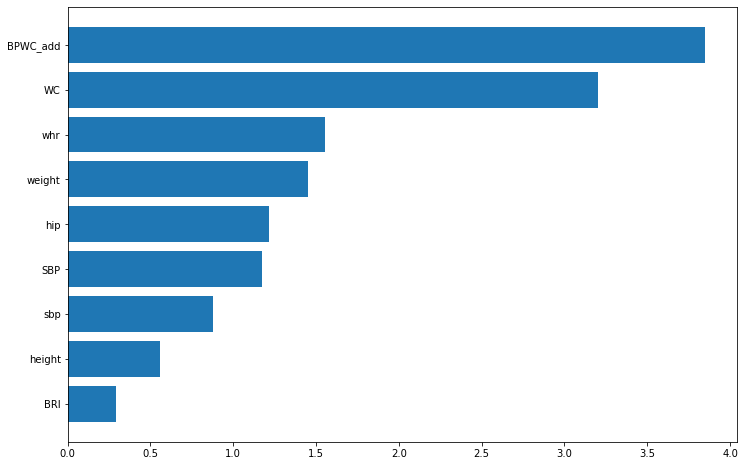

In [165]:
fts = get_feature_importance(np.exp(model.coef_.reshape(-1)), sX_train.loc[:,best_ft].columns, 30, is_abs=False)

plt.figure(figsize=(12,8))
plt.barh(fts['feature'], fts['importance'])
plt.gca().invert_yaxis()
plt.show()

### Model Tuning

In [167]:
args = {'penalty' : 'l1','random_state' : 100}

param_grid ={
    'C' : [100, 10, 5, 1.0, 0.1, 0.05, 0.01],
    'solver' : ['liblinear', 'saga']}

kf = KFold(random_state=100,
           n_splits=5,
           shuffle=True
          )

# define grid_search
grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid, 
                           cv=kf, 
                           scoring='roc_auc',
                           n_jobs=-1, 
                           verbose=1
                          )

grid_search.fit(X_train.loc[:,best_ft], y_train)
#grid_search.best_params_

best_model = LogisticRegression(**grid_search.best_params_,**args,max_iter=1000)
best_model.fit(X_train.loc[:,best_ft],y_train)

prob = best_model.predict_proba(X_valid.loc[:,best_ft])
get_metric(prob, y_valid, 0.5)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


{'acc': 0.7752176139272914,
 'bac': 0.7986866374625342,
 'recall': 0.8376288659793815,
 'ppv': 0.463623395149786,
 'npv': 0.9496805111821086,
 'sepecificity': 0.759744408945687,
 'f1': 0.5968778696051423,
 'auc': 0.8697572543723856}